In [1]:
from LorenzEDMD.EDMD.EDMD import EDMD_CHEB
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
import pickle
from LorenzEDMD.utils.data_processing import (
    normalise_data_chebyshev, 
    get_acf,
    Koopman_correlation_function,
    )
from LorenzEDMD.dynamical_system.Lorenz import lorenz63
from LorenzEDMD.EDMD.EDMD import TSVD, Projection_Koopman_Space
import matplotlib
import plotly.graph_objects as go
from tqdm import tqdm
from LorenzEDMD.utils.paths import get_data_folder_path

matplotlib.rcParams.update({
    "text.usetex": True,  # Use LaTeX to render text
    "font.family": "serif",  # Use serif font (default in LaTeX)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: better math support
})

In [2]:
data_path = get_data_folder_path()
f_name = "edmd_smalldt.pkl"#"edmd_prova.pkl"

with open(data_path / f_name,"rb") as f:
    results = pickle.load(f)

EDMDS : List[List[EDMD_CHEB]] = results["edmd results"]
lorenz : lorenz63 = results["lorenz settings"] 

degrees = [x[0].degree for x in EDMDS]
flight_times = [x.flight_time for x in EDMDS[0]]

#### Fix a degree, regularise and get spectral properties

In [3]:
degree_number = -3
degree = degrees[degree_number] 
edmd_flight_times = EDMDS[degree_number]
edmd : EDMD_CHEB = edmd_flight_times[0] 
print(degree)

18


In [4]:
# Regularisation with TSVDS
tsvd_regulariser = TSVD(rel_threshold=1e-5)
Kreduced = tsvd_regulariser.decompose(edmd)

# Get spectral properties
tsvd_regulariser.get_spectral_properties()
tsvd_regulariser.find_continuous_time_eigenvalues(lorenz_model=lorenz,edmd=edmd)

#### Evaluate correlation functions for Koopman Eigenfunctions

In [5]:
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 10
lorenz_cf_traj.t_span = (0,10000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

100%|██████████| 10000000/10000000 [01:27<00:00, 114794.23it/s]


### Correlation Functions of Koopman Eigenfunctions

In [6]:
PHI_TRAJ = edmd.evaluate_koopman_eigenfunctions_reduced(scaled,tsvd_regulariser)

In [7]:
numbers = [1,3,4,6,8]
nlags = 1500
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time

/Users/niccolo/Desktop/Response_Lorenz_Koopman/.venv/lib/python3.10/site-packages/numpy/_core/_asarray.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


Text(0.5, 0, '$t$')

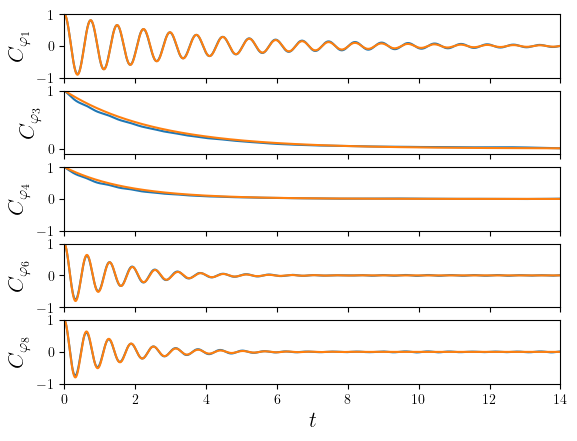

In [8]:
fig , ax = plt.subplots(len(numbers),sharex=True)

for i,number in enumerate(numbers):
    lags, cf = get_acf(PHI_TRAJ[:,number], nlags = nlags,Dt=Dt)
    cf_th = np.real(np.exp(tsvd_regulariser.lambdas[number]*lags))
    ax[i].plot(lags,cf/cf[0])
    ax[i].plot(lags,cf_th /cf_th[0] )
    ax[i].set_xlim(0,14)
    
    ax[i].set_ylim(-1,1)
    if i ==1 :
        ax[i].set_ylim(-0.1,1)
    ax[i].set_ylabel(fr"$C_{{ \varphi_{number} }}$",size=16)
ax[-1].set_xlabel("$t$",size=16)    

### Correlation functions of observables

In [35]:
### Decomposition of observables on dictionary: exact decomposition
decompositions = edmd.get_decomposition_observables()
projections_dictionary = decompositions["z"]

### Decomposition on the svd basis
projections_reduced = tsvd_regulariser.project_reduced_space(projections_dictionary)

### Decomposition on the selected Koopman eigenfunctions
koopman_space = Projection_Koopman_Space(threshold_lambda=-2)
koopman_space.set_subspace(tsvd_regulariser)

projections_koopman = koopman_space.project_to_koopman_space(projections_reduced)

# Reconstruct the correlation function
K_corr = koopman_space.reconstruct_correlation_function(projections_koopman,projections_koopman)

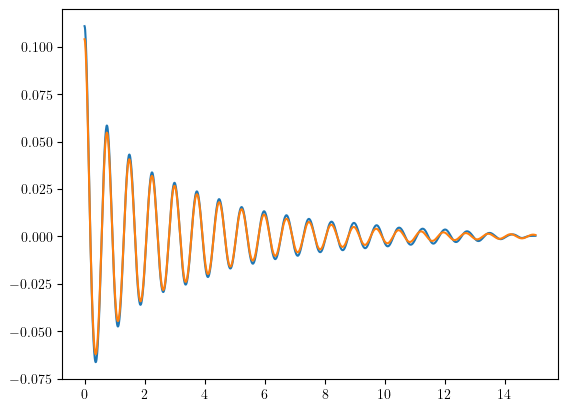

In [16]:
# Numerical correlation function
x, y, z = scaled[:,0], scaled[:,1] ,scaled[:,2]

obs = z
lags, cf = get_acf(obs, nlags = nlags,Dt=Dt)
cf_koop = np.asarray([K_corr(lag) for lag in lags])

fig, ax = plt.subplots()
ax.plot(lags,cf)
ax.plot(lags,np.real(cf_koop))

### Response Theory

In [50]:
### From time series
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 100
lorenz_cf_traj.t_span = (0,100000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

xmax , ymax, zmax = data_max
xmin, ymin, zmin = data_min
scale = (zmax - zmin) / 2 

scale = {
    "x" : (xmax - xmin) / 2 , 
    "y" : (ymax - ymin) / 2,
    "z" : (zmax- zmin) / 2,
    "x^2" : ( (xmax - xmin) / 2 )**2,
    "y^2" : ((ymax - ymin) / 2)**2,
    "z^2" : ((zmax- zmin) / 2) **2,
    "xy" : (xmax - xmin) / 2 * (ymax - ymin) / 2
}

 15%|█▍        | 14810318/100000000 [02:09<12:22, 114788.65it/s]


KeyboardInterrupt: 

In [19]:
batch_size = 100_000
n_total = scaled.shape[0]
range_batches = range(0, n_total, batch_size)
n_batches = len(range_batches)

# Optional: get output shape from one batch
example = edmd.evaluate_dictionary_batch(scaled[:1, :])
avgs = np.zeros(example.shape[1])

for i in tqdm(range_batches):
    batch = scaled[i:min(i + batch_size, n_total), :]
    Psi_trajectory = edmd.evaluate_dictionary_batch(batch)
    x_traj = batch[:, 0]
    avgs += np.mean(x_traj[:, None] * Psi_trajectory, axis=0)

avgs /= n_batches


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


In [48]:
# Working in full space
Ay = edmd.build_derivative_matrix(direction=1)
scalar_product_Gamma = Ay.T @ avgs
Gamma_projections = (tsvd_regulariser.Ur @ np.diag( 1 / (tsvd_regulariser.Sr + 0.01 )) @ tsvd_regulariser.Ur.T  ) @ scalar_product_Gamma
# SVD
Gamma_projections_reduced = tsvd_regulariser.project_reduced_space(Gamma_projections)

### Decomposition on the selected Koopman eigenfunctions
koopman_space = Projection_Koopman_Space(threshold_lambda=-100)
koopman_space.set_subspace(tsvd_regulariser)
Gamma_projections_koopman = koopman_space.project_to_koopman_space(Gamma_projections_reduced)

projections_koopman = koopman_space.project_to_koopman_space(projections_reduced)
# Reconstruct 
G_koop = koopman_space.reconstruct_correlation_function(coefficients_f=projections_koopman,coefficients_g=Gamma_projections_koopman)
Green_Function_Koopman = np.array([G_koop(lag) for lag in lags])

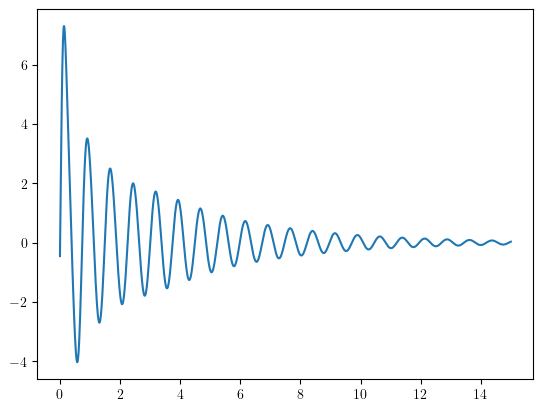

In [49]:
fig, ax = plt.subplots()
ax.plot(lags,np.real(Green_Function_Koopman)*scale["z"])

In [ ]:
f_name = "response_cluster.pkl"
with open(data_path/f_name,"rb") as f:
    response = pickle.load(f)

RP = response["Positive Response"]
RM = response["Negative Response"]
amplitudes = response["Amplitudes"]

Gs = []
for rp, rm, eps in zip(RP,RM,amplitudes):
    G = (rp -rm) / (2*eps)
    Gs.append(G)
# response["Positive Response"]

observable_index = {
    "x" : 0,
    "y" : 1,
    "z" : 2,
    "x^2" : 3,
    "y^2" : 4,
    "z^2" : 5
}

tspan = response["Response Settings"].t_span 
t = np.arange(tspan[0],tspan[-1],response["Response Settings"].dt )
tresp = t[::response["Response Settings"].tau]

G = np.zeros(Gs[0].shape)
for g in Gs:
    G += g / len(Gs)

In [ ]:
lambdas_good,G_koop_n, fn = get_koopman_coefficients(decompositions["z"])

Gkoop = lambda t: Koopman_correlation_function(t,G_koop_n,fn_z,koopman_Gamma_2,lambdas_good )
Gkoop = np.array( [np.real( Gkoop(lag) ) for lag in lags] )
GreenKoopPhysicalSpace = Gkoop*scale["z"]
plt.plot(tresp,G[:,observable_index["z"]],label="Numerics")
plt.plot(lags[1:],GreenKoopPhysicalSpace[1:], label="Koopman Reconstruction") 
plt.xlim(-1,15)
plt.grid('--',alpha=0.2)
plt.xlabel("$t$",size=18)
plt.ylabel("$G_z(t)$",size=18)
plt.legend()
#plt.xlim(-1,1)
#plt.savefig("Koopman_Reconstruction_Green_Function_18.png",dpi=500)


In [ ]:
from scipy.io import savemat

Data = {
    't_response_numerical': tresp,
    'Green_function_numerical' : G[:,observable_index["z"]],
    't_response_koopman' : lags[1:],
    'Green_function_koopman ' : GreenKoopPhysicalSpace[1:]
}

savemat('Response_Lorenz_Z.mat',Data)


In [ ]:
data_path = get_data_folder_path()
fname = 'Green_Function_Koopman_Z_porcodio.txt'
np.savetxt(data_path/fname,GreenKoopPhysicalSpace[1:])

In [ ]:
lambdas_good,G_koop_n, fn = get_koopman_coefficients(decompositions["z"])

Gkoop = lambda t: Koopman_correlation_function(t,G_koop_n,fn,koopman_Gamma_2,lambdas_good )
Gkoop = np.array( [np.real( Gkoop(lag) ) for lag in lags] )
plt.plot(tresp,G[:,observable_index["z"]],label="Numerics")
plt.plot(lags,Gkoop*scale["z"], label="Koopman Reconstruction") 
plt.xlim(-1,15)
plt.grid('--',alpha=0.2)
plt.xlabel("$t$",size=18)
plt.ylabel("$G_z(t)$",size=18)
plt.legend()
#plt.xlim(-1,1)
#plt.savefig("Koopman_Reconstruction_Green_Function_18.png",dpi=500)